In [ ]:
@https://github.com/16gs24/instacart-embeddings/tree/master

In [ ]:
# Finding similarites in items in instacart dataset from Kaggle

In [2]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from datetime import datetime
%matplotlib inline

In [3]:
# loading datasets from instacart dataset

orders = (pd.read_csv('./data/order_products__train.csv')
          ._append(pd.read_csv('./data/order_products__prior.csv'))
         )
products = pd.read_csv('./data/products.csv')

In [4]:
relevant_cols = ['order_id','product_name']

#downsample while I test the code for faster iteration on syntax. run full dataset before commit.
sample_size = 1

baskets = (orders
           .merge(products,on='product_id',how='left')
           .sample(frac=sample_size)
          )[relevant_cols]

#memory management on my local computer
del([orders,products])

In [5]:
baskets.sort_values(['order_id']).head(20)

,order_id,product_name
5,1,Bag of Organic Bananas
1,1,Organic 4% Milk Fat Whole Milk Cottage Cheese
2,1,Organic Celery Hearts
6,1,Organic Hass Avocado
3,1,Cucumber Kirby
0,1,Bulgarian Yogurt
4,1,Lightly Smoked Sardines in Olive Oil
7,1,Organic Whole String Cheese
1384623,2,Original Unflavored Gelatine Mix
1384622,2,Carrots


### Embedding Size

This will matter as we use gensim's word2vec implementation for this task. The learning task for word2vec is predicting the a missing word given a window of words around it using a single hidden layer.  Rather than caring about the quality of the prediction, the weights of the hidden layer are what represent the product embedding that we will use. The number of neurons in the hidden layer is a tunable parameter. Unfortunately, there isn't great guidance on select for this, but eyeballing the resulting embeddings can give guidance on quality of fit. Some people recommend using the 4th root of unique tokens in our corpus, which I'll try.

A tunable parameter for the algorithm is the context window, how many words around the target word to use for our prediction task. Given the lack of order, we will want to use the size of the largest basket, 145 for this parameter.

In [6]:
num_items = baskets.product_name.nunique()
embedding_size = np.floor(num_items**0.25).astype('int')
print('''Let's use vectors of length {n} for {tokens} products'''.format(n=embedding_size, tokens = num_items))

biggest_basket = np.max(baskets.groupby('order_id').product_name.nunique())
print('''The biggest basket (window in our algorithm) will be {}'''.format(biggest_basket))

Let's use vectors of length 14 for 49685 products
The biggest basket (window in our algorithm) will be 145


### Shaping our Data
The gensim implementation of word2vec expects each document to be a list. Traditionally, each document is a list of words. In this case, each basket is a list of products. We will use the product name, which will be more expensive in memory but will make interpretation easier.

In [7]:
df_of_basket_lists = (baskets
        .groupby('order_id')
        .apply(lambda baskets :
                baskets.product_name
                .tolist()
               )
       )

#memory management
del(baskets)

In [8]:
df_of_basket_lists.head()
print(len(df_of_basket_lists))

3346083


In [10]:
model = Word2Vec(df_of_basket_lists, vector_size=embedding_size, window=biggest_basket)

In [11]:
def cosine_similarity(word_u,word_v,model):
    """
    Cosine similarity gets the similarity for two products and computes the similarity 
    between two embeddings in our word2vec model
        
    Arguments:
        u - numpy array of shape (n,)        
        v - numpy array of shape (n,)

    Returns:
        cosine similarity between words u & v
    """
    #get embeddings from gensim model
    u = model.wv[word_u]
    v = model.wv[word_v]

    #compute similarity
    dot = np.dot(u, v)
    norm_u = np.sqrt(np.sum(u * u))
    norm_v = np.sqrt(np.sum(v * v))
    cosine_similarity = dot / (norm_u * norm_v)
    
    return cosine_similarity

In [12]:
#a pair of similar identity items
cosine_similarity('Organic Whole Milk','Organic Reduced Fat Milk',model)

0.9447289

In [13]:
# a pair of similar items within a department
cosine_similarity('Bag of Organic Bananas','Limes',model)

0.38785997

In [14]:
# a pair of very different items
cosine_similarity('Bag of Organic Bananas','Party Tumblers',model)

-0.39784408

In [16]:
cosine_similarity('100% Columbian Coffee', 'Coffee Liqueur', model)

0.6587412

In [17]:
cosine_similarity('100% Columbian Coffee', 'Natural Cane Turbinado Sugar', model)

-0.01499318

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.index_to_key), sample)
#            words = np.random.choice(list(model.vocab.keys()), sample)

        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(16,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

In [35]:
model.wv.most_similar('Chicken Fingers')


[('Rainforest Blend Coffee K-Cups', 0.9182653427124023),
 ('Red Raspberry Scones Mix', 0.8793126344680786),
 ('Organic Bucatini', 0.8757637143135071),
 ('Rainbow Sherbet Ice Cream', 0.8604529500007629),
 ('Potstickers, Chicken & Vegetable Dumplings', 0.8598121404647827),
 ('Soft Taco Size Flour Tortillas 10 Count', 0.845432460308075),
 ('Breakfast Links Maple & Smoked Bacon Smoked Chicken Sausage',
  0.8442323803901672),
 ('Organic Mint Confetti Ice Cream', 0.831736147403717),
 ('Organic Grass-Fed Ground Beef 85/15', 0.8308544158935547),
 ('The Great Organic Uncured Stadium Beef Hot Dog', 0.8282213807106018)]

In [36]:
# same aisle same category
products_draw = ['Spicy Chicken Breast Patties', 'Gluten Free Crispy Battered Haddock',
'Key West Pink Shrimp', 
'Potato Crunch Fish Fillets', 
'Classic Seasoning with Lemon Skillet Crisp Tilapia',
'Mini Crispy Crabless Cakes',
'Whole Grain Breaded Chicken Breast Chunks',
'Chipotle Black Bean Burger',
'Cracked Peppercorn Tilapia', 
'Angus Beef Meatballs',
'Crispy Strips',
'Chicken Fingers',
'Patties, Beef, Quarter Pound',
'Original Turkey Burgers Smoke Flavor Added',
'Tortilla Crusted Tilapia',
'Crispy Chicken',
'Breaded Vegan Coconut Shrimp',
'Breaded Chicken Patties',
'Crab Cakes',
'Breaded Nuggets Chicken Breast']

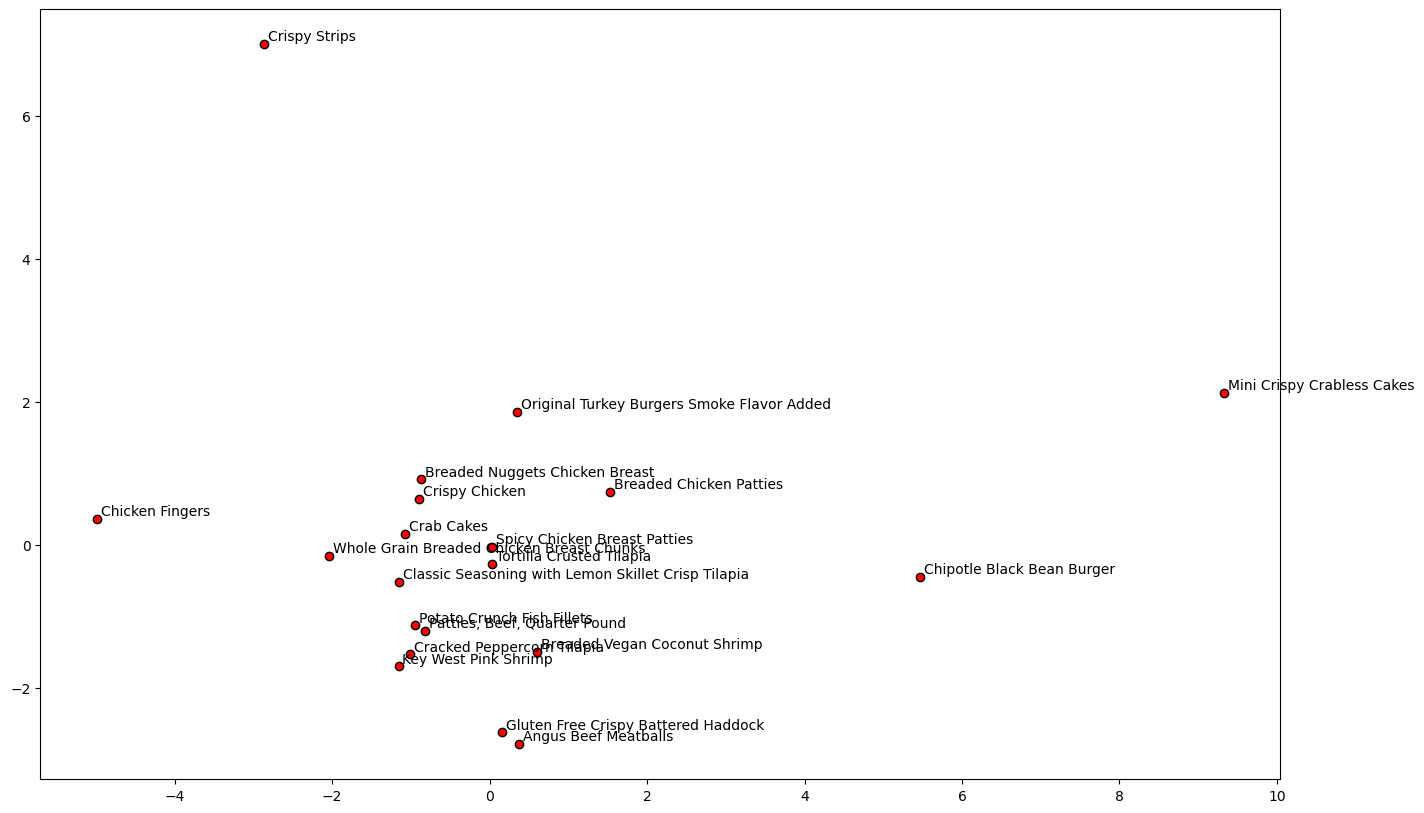

In [34]:
display_pca_scatterplot(model.wv, products_draw)
plt.show()